In [8]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
import cartopy.crs as ccrs

warnings.filterwarnings('ignore')
import global_land_mask
import xesmf as xe
import warnings
import geopandas as gp
import regionmask
import sys
import pandas as pd
from datetime import datetime
from scipy import stats
import cartopy.feature as cfeature
# Import local files
cmip6_sd = '../Farallon/QIN/CMIP6-downscale'
sys.path.append(cmip6_sd)
cmip6_is = '../Farallon/QIN/CMIP6-downscale/isimip3basd'
sys.path.append(cmip6_is)
import CMIP6_ridgeplot
from tabulate import tabulate
xr.set_options(display_style='text')
plt.style.use('default')

In [9]:

def create_land_ocean_mask(ds: xr.Dataset) -> xr.DataArray:
    """
    Function that creates land mask based on its longitude - latitude.
    Returns a DataArray to be included in a Dataset and used for extrapolation
    in xesmf.
    """
    print("[CMIP6_analyse] Running create_land_ocean_mask for")

    if ds.lon.ndim == 1:
        lon = ds.lon.values
        lat = ds.lat.values
    elif ds.lon.ndim == 2:
        lon = ds.lon[0,:].values
        lat = ds.lat[:,0].values
    else:
        raise Exception("Unable to understand dimensions of longitude/latitude: {}".format(cmip6_grid.lon.ndim))

    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid)

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon']).astype(int)


In [10]:
def create_map(df, var_name):
    resolution='50m'
    ax = plt.figure(figsize=(16,10)).gca(projection=ccrs.NorthPolarStereo())
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ax.add_feature(land_50m, color="lightgrey", edgecolor="black")
    ax.set_extent([-180, 180, 0, 90], ccrs.PlateCarree())

    ax.coastlines(resolution=resolution, linewidth=0.5, color="black", alpha=1.0, zorder=4)
    ax.add_feature(cpf.BORDERS, linestyle=':',alpha=0.9)
    ax.add_feature(cpf.LAND, color="lightgrey")

    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)


    cs=ax.contourf(df["lon"], df["lat"], df, #df[var_name],
                    transform=ccrs.PlateCarree(),
        cmap=sns.color_palette("Spectral_r", as_cmap=True), extend="both")

    clb_label='{}'.format(var_name)
   # x,y=np.meshgrid(df["lon"], df["lat"])
   # ax.scatter(x,y,0.2,c="r",transform=ccrs.PlateCarree())
    clb = plt.colorbar(cs, shrink=0.5, extend="both")
    if var_name in ["thetao"]:
        clb.set_label('Bottom temperature ($^{o}C$)')
    else:
        clb.set_label('test')

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")


    #plt.savefig("../../GOA-Laurel/Figures/Bottom_{}_july_sept_250m_{}.png".format(var_name, period), dpi=300,
    #            facecolor='w',
    #                transparent=False,
    #                bbox_inches = 'tight',
    #                pad_inches = 0)

    plt.show()

In [11]:
def calc_trend(xarr: xr.DataArray):
    # getting shapes

    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    # creating x and y variables for linear regression
    #
    # Some CMIP6 models return CFTimeIndex while others return DatetImeIndex - need the latter
    # to convert to Datetime objects
    if isinstance(xarr.time.to_pandas().index, pd.DatetimeIndex):
        x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    else:
        x = xarr.time.to_pandas().index.to_datetimeindex().to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss) ** 0.5
    t = r * (df / ((1 - r) * (1 + r))) ** 0.5
    p = stats.distributions.t.sf(abs(t), df)
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / month'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p
    xarr_out = xarr_out.expand_dims('time')
    return xarr_out

In [12]:
def convert_to_DataArray(var_name: str,
                         times: np.ndarray,
                         lats: np.ndarray,
                         lons: np.ndarray,
                         data_array: np.ndarray,
                         depths: np.ndarray = None) -> xr.DataArray:

    coords = {"time": times,
              "lat": lats,
              "lon": lons}
    dims = ["time", "lat", "lon"]

    if depths is not None:
        coords["depth"] = depths
        dims.insert(0, "depth")

    return xr.DataArray(
        name=var_name,
        data=data_array,
        coords=coords,
        dims=dims)

def calculate_detrended_climatology(da: xr.DataArray, var_name: str, description: str = "") -> xr.Dataset:
    print("[CMIP6_downscale] Running calculation of climatology")

    trend_stats = calc_trend(da)

    if da.lat.ndim == 2:
        lons = da.lon[0, :].values
        lats = da.lat[:, 0].values
    else:
        lons = da.lon.values
        lats = da.lat.values
    times = da["time"].values

    print("[CMIP6_downscale] Average before de-trending {}: {:3.3f}".format(description,
                                                                              np.nanmean(da)))

    # Remove the trend difference from the time-series: the difference is y=ax and not y=ax+b
    y = [(da[i, :, :].values - (trend_stats.slope.values * i)) for i in range(len(times))]

    # Organize the de_trended data into dataset
    de_trended_data = np.zeros((len(times), len(lats), len(lons)))
    for time_index, de_trended_at_timestep in enumerate(y):
        de_trended_data[time_index, :, :] = de_trended_at_timestep[:, :]

    print("[CMIP6_downscale] Average after de-trending {}: {}".format(description,
                                                                             np.nanmean(de_trended_data)))

    ds_de_trended = convert_to_DataArray(var_name, times, lats, lons, de_trended_data).to_dataset()

    # Calculate the climatology and the anomalies from the de-trended dataset
    return ds_de_trended.groupby("time.month").mean("time", keep_attrs=True)

     ECO_CODE                    ECOREGION  PROV_CODE  \
0     20192.0                 Agulhas Bank       51.0   
1     20053.0             Aleutian Islands       10.0   
2     20072.0                     Amazonia       13.0   
3     20194.0            Amsterdam-St Paul       52.0   
4     20228.0  Amundsen/Bellingshausen Sea       61.0   
..        ...                          ...        ...   
227   25034.0                   Ionian Sea        4.0   
228   25031.0                   Aegean Sea        4.0   
229   25036.0                  Alboran Sea        4.0   
230   25035.0        Western Mediterranean        4.0   
231   25010.0      High Arctic Archipelago        1.0   

                             PROVINCE  RLM_CODE                        REALM  \
0                             Agulhas      10.0    Temperate Southern Africa   
1    Cold Temperate Northeast Pacific       3.0   Temperate Northern Pacific   
2                  North Brazil Shelf       4.0            Tropical Atlanti

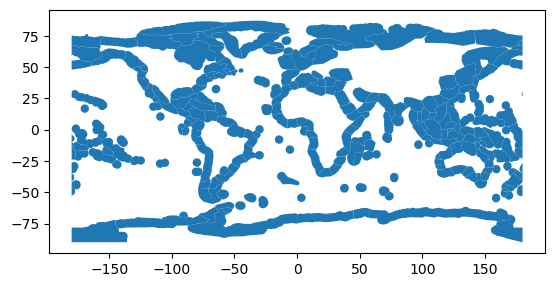

In [13]:
scenarios=["ssp585"]
ensemble_id="r1i1p1f1"
period="1950-01-01-2099-12-16"
models=["MPI-ESM1-2-LR"]

meow = gp.read_file("MEOW-TNC/meow_ecos.shp")
meow.plot()

print(meow)

def create_ridge_plot(df:pd.DataFrame, var_name:str, project:str):

    df_period1 = df[(df.time >= datetime(2020,1,1)) &
                    (df.time <= datetime(2030,1,1))]
    df_period2 = df[(df.time >= datetime(2050,1,1)) &
                    (df.time <= datetime(2060,1,1))]
    df_period3 = df[(df.time >= datetime(2080,1,1)) &
                    (df.time <= datetime(2090,1,1))]

    df_period1_ens=df_period1.groupby([df_period1.time.dt.month])
    df_period1_ens = df_period1_ens.aggregate({var_name:np.mean})

    df_period2_ens=df_period2.groupby([df_period2.time.dt.month])
    df_period2_ens = df_period2_ens.aggregate({var_name:np.mean})

    df_period3_ens=df_period3.groupby([df_period3.time.dt.month])
    df_period3_ens = df_period3_ens.aggregate({var_name:np.mean})

    df_period1_ens=df_period1_ens.reset_index('time')
    df_period2_ens=df_period2_ens.reset_index('time')
    df_period3_ens=df_period3_ens.reset_index('time')

    labels=["{}-{}".format("2020","2030"), "{}-{}".format("2050","2060"), "{}-{}".format("2080","2090")]

    df = df_period1_ens

    df[var_name] = df_period1_ens[var_name]
    df["Proj"] = df_period2_ens[var_name]
    df["Proj2"] = df_period3_ens[var_name]

    df=df.rename(columns={"time":"month"})
    print(tabulate(df.head(12), headers='keys', tablefmt='presto'))
    CMIP6_ridgeplot.CMIP6_ridgeplot().create_ridgeplot(var_name, df, "{}/ridgeplot_{}.png".format(project,var_name), labels)

test_datasets/Light_MPI-ESM1-2-LR_r1i1p1f1_1950-01-01-2099-12-16_scenario_osa_ssp585.nc
<xarray.DataArray 'PAR' (time: 1800, lat: 90, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., n

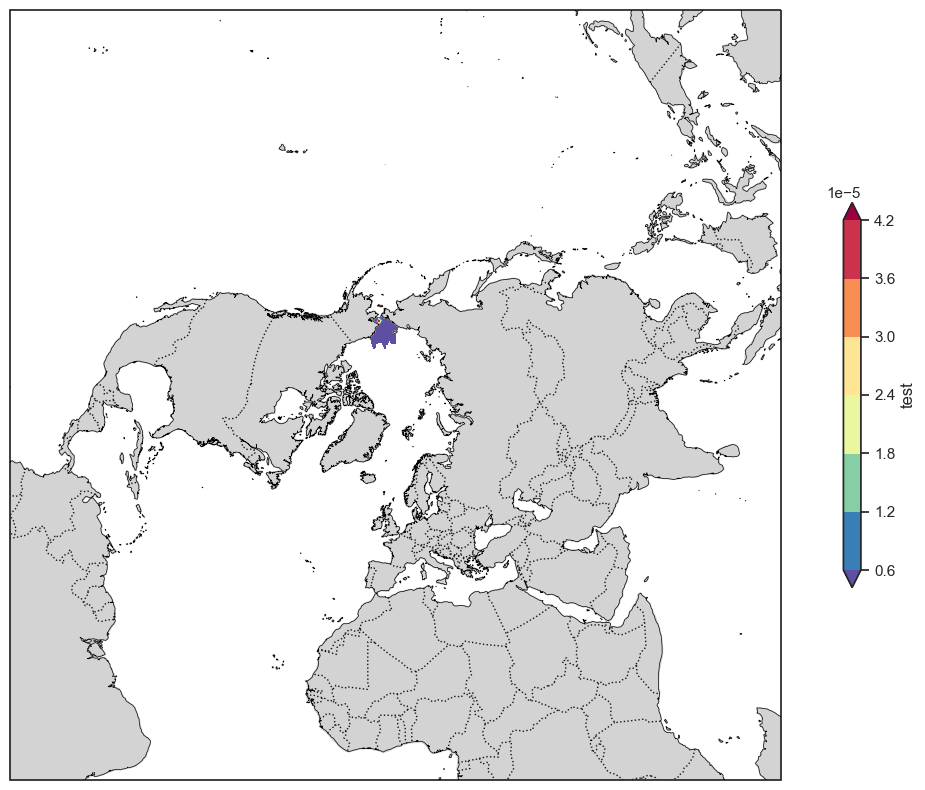

 time                |   lat |   PAR | time
---------------------+-------+-------+---------------------
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
 1950-01-16 12:00:00 |   0.5 |   nan | 1950-01-16 12:00:00
    |   month |        PAR |        Proj |      Proj2
----+---------+------------+-------------+------------
  0 |       1 | 2.4688e-05 | 0.000645427 | 0.00183116
  1 |       2 | 0.00152357 | 0.00642632  | 0.0266642
  2 |       3 | 0.00146452 | 0.0170431   | 0.0700778
  3 |       4 | 0.00225963 | 0.030904

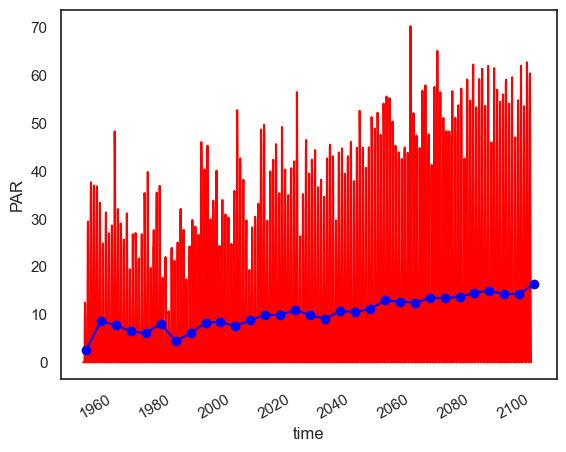

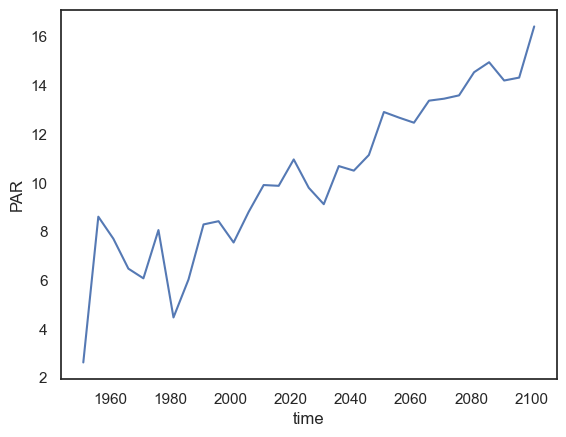

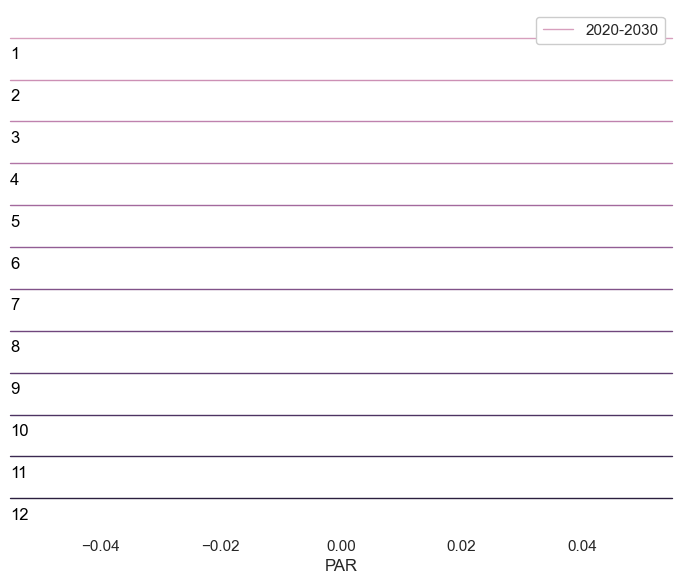

In [32]:
var_name="PAR"

for scenario in scenarios:
    for model in models:
        fname="test_datasets/Light_{}_{}_{}_scenario_osa_{}.nc".format(model, ensemble_id,period,scenario)
        ba = xr.open_dataset(fname)
        print(fname)
   #     ba["mask"] = create_land_ocean_mask(ba)
    #    create_map(ba.isel(time=0), "PAR")

        lon = np.arange(0.5, 360)

        # The mask first identifes all polygons or ecoregions within the PROV_CODE == 1 (Arctic)
        mask = regionmask.mask_geopandas(meow[(meow.PROV_CODE==1) & (meow.ECOREGION=="Chukchi Sea")], lon, ba.lat)
#        mask = regionmask.mask_geopandas(meow[(meow.PROV_CODE==1)], lon, ba.lat)

        da = ba[var_name][::3,:,:].where( mask < 2000)
        print(da)
        climatology = calculate_detrended_climatology(da,
                                                                  var_name,
                                                                   description="clim")

        create_map(da.isel(time=0), var_name)

       # da_annual = da.groupby("time.month") - climatology

        da_monthly = da.mean({"lat","lon"}, skipna=True).resample(time="1M").mean().to_dataset()
        da_annual = da.mean({"lat","lon"}, skipna=True).resample(time="5A").mean().to_dataset()

    #    xr.plot.scatter(da_annual,x="time",y=var_name)
        xr.plot.line(da_monthly[var_name],x="time",color="red")
        xr.plot.line(da_annual[var_name],x="time",color="blue", marker="o")

        fig, axes = plt.subplots(1, 1)

        ax = sns.lineplot(ax=axes, data=da_annual, x="time", y=var_name, ci=95, alpha=0.95)

        df = da.to_dataframe()
        df = df.reset_index(level=[0,1])
        df = df.set_index("time")

       # fig, axes = plt.subplots(1, 1)
       # ax = sns.lineplot(ax=axes, data=df, x="time", y=var_name, ci=95, alpha=0.95)

        df['time'] = df.index

        print(tabulate(df.head(10), headers='keys', tablefmt='presto'))
        create_ridge_plot(df, var_name, "light")